In [2]:
# Install PyTorch Geometric dependencies
!pip install torch-scatter torch-sparse torch-cluster torch-spline-conv -f https://data.pyg.org/whl/torch-2.1.0+cu121.html

# Install PyTorch Geometric itself
!pip install torch-geometric

Looking in links: https://data.pyg.org/whl/torch-2.1.0+cu121.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.8/10.8 MB 106.7 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.1/5.1 MB 83.7 MB/s eta 0:00:00:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 56.4 MB/s eta 0:00:0000:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 936.0/936.0 kB 45.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.7/63.7 kB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 29.0 MB/s eta 0:00:0000:01


In [6]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder, MinMaxScaler, StandardScaler
from sklearn.cluster import KMeans, DBSCAN
from sklearn.metrics import silhouette_score
from sklearn.manifold import TSNE
import torch
import torch.nn.functional as F
from torch_geometric.data import Data
from torch_geometric.nn import GCNConv
import matplotlib.pyplot as plt

In [10]:
import pandas as pd
import numpy as np

# ... (বাকি import যেমন আছে তেমন থাকবে)

# Load and preprocess
file_path = "/kaggle/input/food-dataset/bangladesh-food-prices-2.csv" 
df = pd.read_csv(file_path)

# ১. #date যুক্ত সারি বাদ দেওয়া
df = df[df['date'] != '#date'].copy()

# ২. 'date' কলামকে datetime-এ রূপান্তর
df['date'] = pd.to_datetime(df['date'])

# ৩. 'price' কলামকে সংখ্যাসূচকে রূপান্তর (আগের TypeError ঠিক করার জন্য)
df['price'] = pd.to_numeric(df['price'], errors='coerce') 

# ৪. NaN ভ্যালু হ্যান্ডলিং (সতর্কবার্তা এড়াতে `.ffill()` ব্যবহার)
# FutureWarning: Series.fillna with 'method' is deprecated... এর সমাধান।
df['price'] = df['price'].ffill() # NaN গুলিকে তার আগের বৈধ মান দিয়ে পূরণ করা হচ্ছে

# ৫. সব NaN ভ্যালু বাদ দেওয়া (যদি সিরিজের শুরুতে NaN থেকে যায়, যা ffill দিয়ে পূরণ করা যায়নি)
df = df.dropna(subset=['price'])

df_metrics = financial_metrics(df)

In [12]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder, MinMaxScaler, StandardScaler
from sklearn.cluster import KMeans, DBSCAN
from sklearn.metrics import silhouette_score
from sklearn.manifold import TSNE
import torch
import torch.nn.functional as F
from torch_geometric.data import Data
from torch_geometric.nn import GCNConv
import matplotlib.pyplot as plt

# ডেটা লোডিং এবং প্রিপোসেসিং (আগের সেশন থেকে সংশোধিত)
# ধরে নেওয়া হচ্ছে df_metrics ডেটাফ্রেমটি আগের উত্তর অনুযায়ী লোড করা হয়েছে এবং price কলাম সংখ্যাসূচক।

# --- (Financial Metrics ফাংশন এখানে আছে ধরে নিচ্ছি) ---

# ডেটা লোডিং (আগের সংশোধিত অংশ)
# file_path = "/kaggle/input/bangladesh-food-prices/bangladesh-food-prices.csv"
# df = pd.read_csv(file_path)
# df = df[df['date'] != '#date'].copy()
# df['date'] = pd.to_datetime(df['date'])
# df['price'] = pd.to_numeric(df['price'], errors='coerce') 
# df['price'] = df['price'].ffill()
# df = df.dropna(subset=['price'])
# df_metrics = financial_metrics(df)


# Categorical encoding and feature scaling
cat_cols = ['cmname', 'unit', 'category', 'country', 'admname', 'mktname']
for col in cat_cols:
    df_metrics[col] = LabelEncoder().fit_transform(df_metrics[col].astype(str))
df_metrics['year'] = df_metrics['date'].dt.year
df_metrics['month'] = df_metrics['date'].dt.month
df_metrics['day'] = df_metrics['date'].dt.day

num_cols = ['year', 'month', 'day', 'price', 'annual_return', 'volatility', 'sharpe', 'variance']
# Fill NaNs before scaling
df_metrics[num_cols] = df_metrics[num_cols].fillna(0)
# স্কেলিং
df_metrics[num_cols] = MinMaxScaler().fit_transform(df_metrics[num_cols])


# RS, VR, YR clustering (কোনো পরিবর্তন নেই)
X_rs = df_metrics[['annual_return', 'sharpe']].fillna(0)
X_vr = df_metrics[['volatility', 'annual_return']].fillna(0)
X_yr = df_metrics[['variance', 'annual_return']].fillna(0)

k_rs = KMeans(n_clusters=3, random_state=42, n_init='auto').fit_predict(X_rs)
k_vr = KMeans(n_clusters=3, random_state=42, n_init='auto').fit_predict(X_vr)
k_yr = KMeans(n_clusters=3, random_state=42, n_init='auto').fit_predict(X_yr)


# Temporal graph (ডেটা টাইপ সংশোধন)
features = df_metrics[cat_cols + num_cols].values.astype(np.float32) # torch-এর জন্য np.float32 ব্যবহার
x = torch.tensor(features, dtype=torch.float)

# এজ তৈরির লজিক ঠিক আছে (টাইম সিরিজ গ্রাফের জন্য)
source_nodes = torch.arange(len(df_metrics)-1)
target_nodes = torch.arange(1, len(df_metrics))
edge_index = torch.stack([source_nodes, target_nodes], dim=0)
data = Data(x=x, edge_index=edge_index)

# GCN এর ইনপুটের জন্য StandardScaler ব্যবহার (ডেটা.এক্স এর উপর)
# এটি আর MinMaxScaler-এর উপর StandardScaler এর দ্বৈত প্রয়োগ নয়
data.x = torch.tensor(StandardScaler().fit_transform(data.x.numpy()), dtype=torch.float)

print(f"GCN Node Features (Input Channels): {data.num_node_features}")

GCN Node Features (Input Channels): 14


Epoch 20/150 | Loss: 0.826164
Epoch 40/150 | Loss: 0.821292
Epoch 60/150 | Loss: 0.817807
Epoch 80/150 | Loss: 0.816599
Epoch 100/150 | Loss: 0.812600
Epoch 120/150 | Loss: 0.806439
Epoch 140/150 | Loss: 0.806486
K=2, Silhouette Score=0.3379
K=3, Silhouette Score=0.3359
K=4, Silhouette Score=0.3672
K=5, Silhouette Score=0.3443
Best K (Silhouette): 4


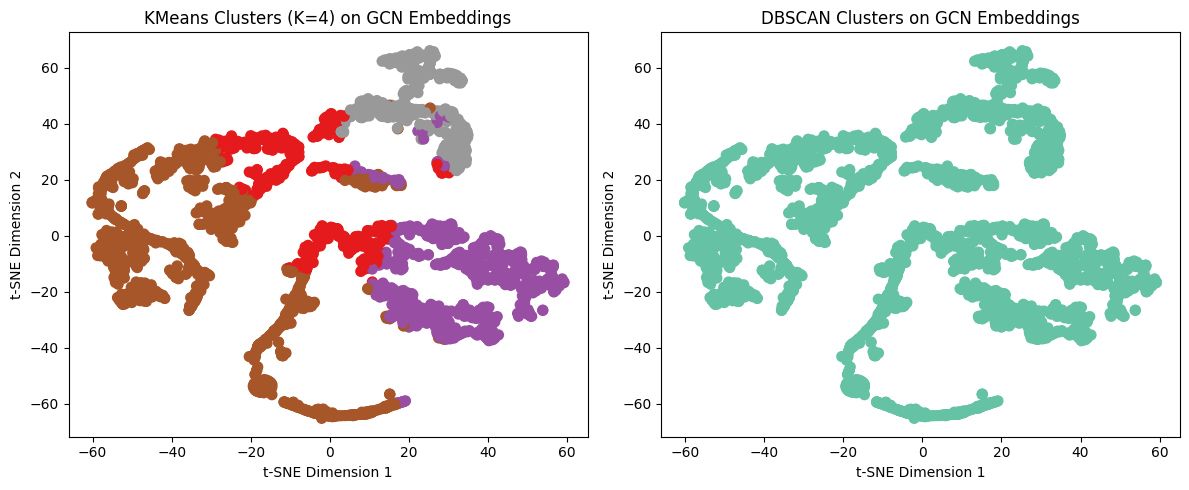

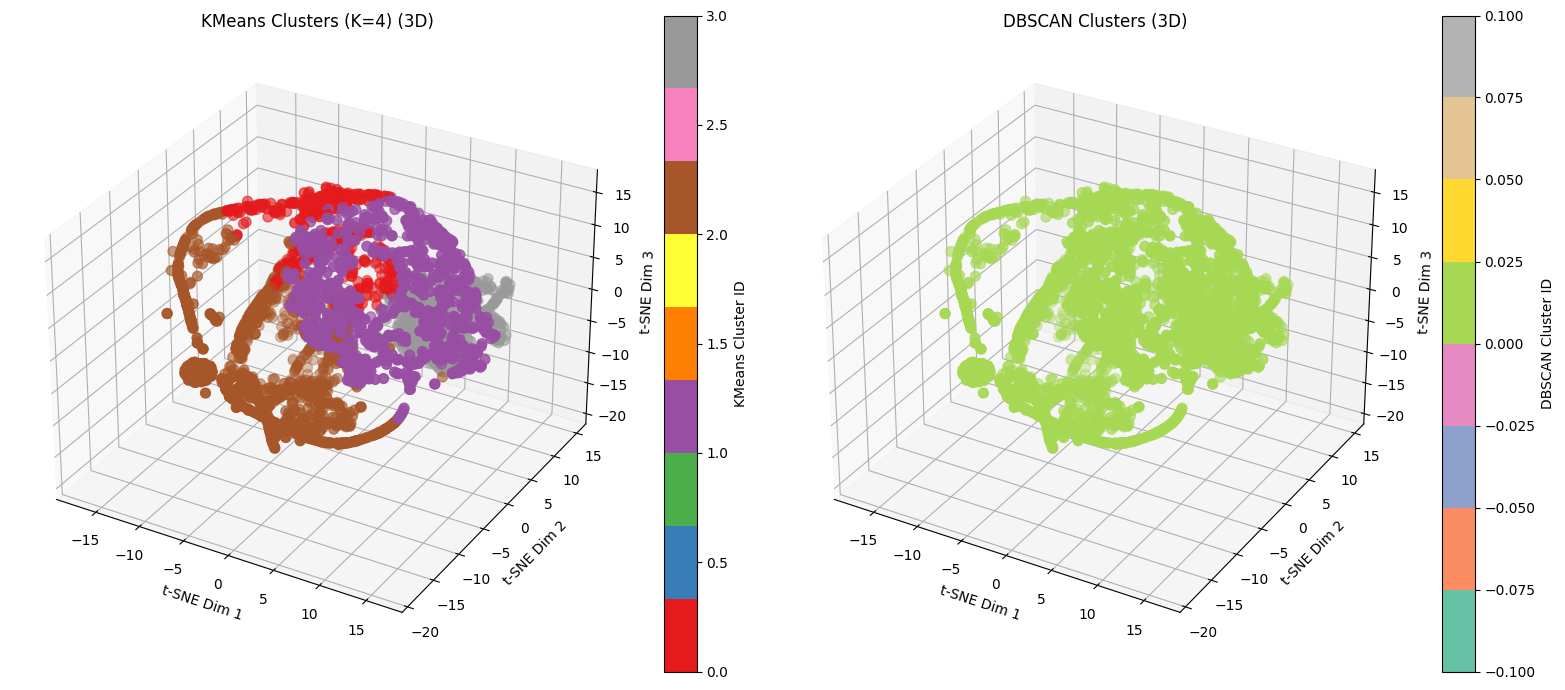

In [15]:
# GCN model
class UpgradedGCN(torch.nn.Module):
    def __init__(self, in_channels, hidden1=16, hidden2=12, out_channels=6, dropout=0.2):
        super().__init__()
        self.conv1 = GCNConv(in_channels, hidden1)
        self.conv2 = GCNConv(hidden1, hidden2)
        self.conv3 = GCNConv(hidden2, out_channels)
        self.dropout = dropout
    def forward(self, x, edge_index):
        x = F.relu(self.conv1(x, edge_index))
        x = F.dropout(x, p=self.dropout, training=self.training)
        x = F.relu(self.conv2(x, edge_index))
        x = F.dropout(x, p=self.dropout, training=self.training)
        x = self.conv3(x, edge_index)
        return x

in_channels = data.num_node_features
out_channels_model = 6
model = UpgradedGCN(in_channels, out_channels=out_channels_model)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
num_epochs = 150

# GCN Autoencoder Training (MSE Loss on latent space)
# লক্ষ করুন: মডেলের আউটপুটকে প্রথম 6টি ইনপুট ফিচারের কাছাকাছি আনার চেষ্টা করা হচ্ছে
# এটি একটি ডিকোডারবিহীন সিম্পল অটোএনকোডার লজিক।
for epoch in range(1, num_epochs+1):
    model.train()
    optimizer.zero_grad()
    embeddings = model(data.x, data.edge_index)
    loss = F.mse_loss(embeddings, data.x[:, :out_channels_model]) # Loss on first 6 input features
    loss.backward()
    optimizer.step()
    if epoch % 20 == 0:
        print(f"Epoch {epoch}/{num_epochs} | Loss: {loss.item():.6f}")

model.eval()
with torch.no_grad():
    embeddings = model(data.x, data.edge_index)
emb_np = embeddings.cpu().numpy()

# KMeans/DBSCAN clustering and silhouette scores on embeddings
sil_scores = []
k_range = range(2, 6)
for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init='auto') # n_init='auto' যোগ করা হয়েছে
    clusters = kmeans.fit_predict(emb_np)
    score = silhouette_score(emb_np, clusters)
    sil_scores.append(score)
    print(f"K={k}, Silhouette Score={score:.4f}")

best_k = k_range[np.argmax(sil_scores)]
print(f"Best K (Silhouette): {best_k}")
kmeans = KMeans(n_clusters=best_k, random_state=42, n_init='auto') # n_init='auto' যোগ করা হয়েছে
clusters_km = kmeans.fit_predict(emb_np)
dbscan = DBSCAN(eps=1.0, min_samples=2)
clusters_db = dbscan.fit_predict(emb_np)

# t-SNE Visualization (2D)
tsne = TSNE(n_components=2, random_state=42)
emb_2d = tsne.fit_transform(emb_np)

plt.figure(figsize=(12, 5)) # সাইজ সামান্য বাড়ানো হলো

# KMeans 2D প্লট
plt.subplot(1, 2, 1)
plt.scatter(emb_2d[:, 0], emb_2d[:, 1], c=clusters_km, cmap='Set1', s=50)
plt.title(f'KMeans Clusters (K={best_k}) on GCN Embeddings')
plt.xlabel('t-SNE Dimension 1')
plt.ylabel('t-SNE Dimension 2')

# DBSCAN 2D প্লট
plt.subplot(1, 2, 2)
plt.scatter(emb_2d[:, 0], emb_2d[:, 1], c=clusters_db, cmap='Set2', s=50)
plt.title('DBSCAN Clusters on GCN Embeddings')
plt.xlabel('t-SNE Dimension 1')
plt.ylabel('t-SNE Dimension 2')
plt.tight_layout()
plt.show()


# ---

# t-SNE Visualization (3D)
tsne_3d = TSNE(n_components=3, random_state=42)
emb_3d = tsne_3d.fit_transform(emb_np)

fig = plt.figure(figsize=(16, 7)) # সাইজ বাড়ানো হলো

# KMeans 3D প্লট
ax1 = fig.add_subplot(1, 2, 1, projection='3d')
scatter1 = ax1.scatter(emb_3d[:, 0], emb_3d[:, 1], emb_3d[:, 2], c=clusters_km, cmap='Set1', s=50)
ax1.set_title(f'KMeans Clusters (K={best_k}) (3D)')
ax1.set_xlabel('t-SNE Dim 1')
ax1.set_ylabel('t-SNE Dim 2')
ax1.set_zlabel('t-SNE Dim 3')
# কালারবার যোগ করা হলো (ঐচ্ছিক)
fig.colorbar(scatter1, ax=ax1, label='KMeans Cluster ID')


# DBSCAN 3D প্লট
ax2 = fig.add_subplot(1, 2, 2, projection='3d')
scatter2 = ax2.scatter(emb_3d[:, 0], emb_3d[:, 1], emb_3d[:, 2], c=clusters_db, cmap='Set2', s=50)
ax2.set_title('DBSCAN Clusters (3D)')
ax2.set_xlabel('t-SNE Dim 1')
ax2.set_ylabel('t-SNE Dim 2')
ax2.set_zlabel('t-SNE Dim 3')
# কালারবার যোগ করা হলো (ঐচ্ছিক)
fig.colorbar(scatter2, ax=ax2, label='DBSCAN Cluster ID')

plt.tight_layout()
plt.show()

In [16]:
# LSTM nodewise forecasting (সংশোধিত)
import torch.nn as nn

class NodeLSTM(nn.Module):
    def __init__(self, input_dim, hidden_dim=64):
        super().__init__()
        self.lstm = nn.LSTM(input_dim, hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, 1)
    def forward(self, x_seq):
        lstm_out, _ = self.lstm(x_seq)
        # lstm_out: (batch_size, seq_len, hidden_dim)
        # আমরা শুধু শেষ স্টেপের আউটপুট ব্যবহার করব
        output = self.fc(lstm_out[:, -1, :])
        return output

# টার্গেট ভ্যালু এবং LSTM সিকোয়েন্স তৈরি (সারলীকরণের জন্য: 5 দিনের সিকোয়েন্স)
def create_sequences(data, seq_len):
    xs, ys = [], []
    for i in range(len(data) - seq_len):
        x = data[i:(i + seq_len)] # 5 দিন ইনপুট
        y = data[i + seq_len, 3] # 6ষ্ঠ দিনের 'price' কলামের পূর্বাভাস (price হচ্ছে num_cols-এর 4র্থ আইটেম, ইনডেক্স 3)
        xs.append(x)
        ys.append(y)
    return torch.stack(xs), torch.stack(ys)

SEQ_LEN = 5
# ইনপুট হিসাবে GCN এম্বেডিংস ব্যবহার করা হলো
input_data = torch.from_numpy(emb_np).float()
X_seq, Y_target = create_sequences(input_data, SEQ_LEN)

print(f"LSTM Input Sequences Shape: {X_seq.shape}")
print(f"LSTM Target Shape: {Y_target.shape}")


node_lstm = NodeLSTM(input_dim=input_data.shape[1], hidden_dim=64)
lstm_optimizer = torch.optim.Adam(node_lstm.parameters(), lr=0.005) # LR কমানো হলো
num_lstm_epochs = 100

# বাস্তব ট্রেনিং লুপ
for epoch in range(1, num_lstm_epochs + 1):
    node_lstm.train()
    lstm_optimizer.zero_grad()
    lstm_out = node_lstm(X_seq)
    
    # লস (Loss) গণনা: LSTM আউটপুট এবং আসল টার্গেট ভ্যালু
    loss_lstm = F.mse_loss(lstm_out.squeeze(), Y_target)
    
    loss_lstm.backward()
    lstm_optimizer.step()
    
    if epoch % 20 == 0:
        print(f"LSTM Epoch {epoch}/{num_lstm_epochs} | Loss: {loss_lstm.item():.6f}")

print(f"\nLSTM Training Complete. Final Loss: {loss_lstm.item():.6f}")
print("LSTM output shape:", lstm_out.shape)

LSTM Input Sequences Shape: torch.Size([3381, 5, 6])
LSTM Target Shape: torch.Size([3381])
LSTM Epoch 20/100 | Loss: 0.000650
LSTM Epoch 40/100 | Loss: 0.000537
LSTM Epoch 60/100 | Loss: 0.000466
LSTM Epoch 80/100 | Loss: 0.000433
LSTM Epoch 100/100 | Loss: 0.000406

LSTM Training Complete. Final Loss: 0.000406
LSTM output shape: torch.Size([3381, 1])


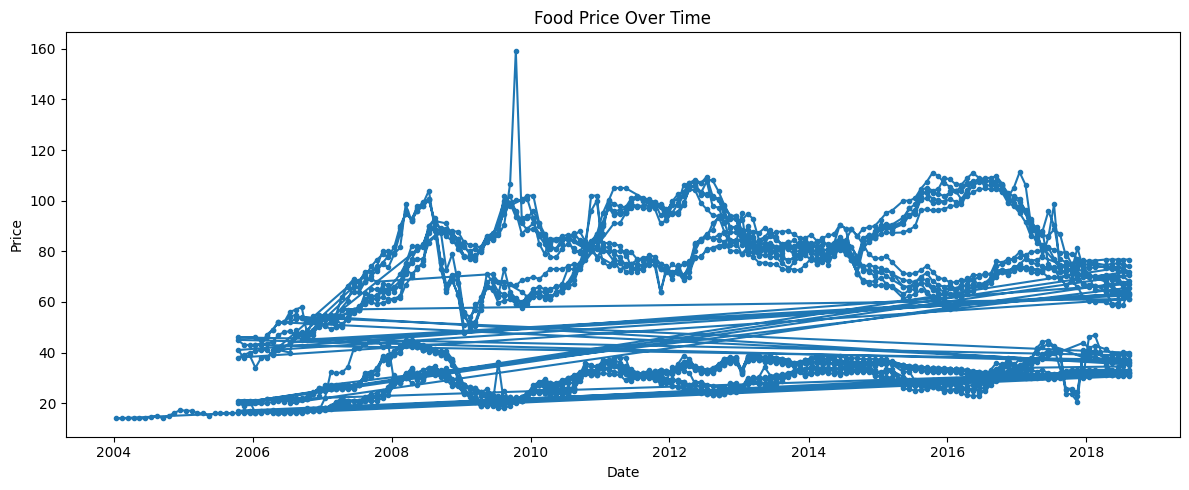

In [18]:
#Line Plot: Original Food Prices Over Time
plt.figure(figsize=(12,5))
plt.plot(df['date'], df['price'], marker='.')
plt.xlabel('Date')
plt.ylabel('Price')
plt.title('Food Price Over Time')
plt.tight_layout()
plt.show()

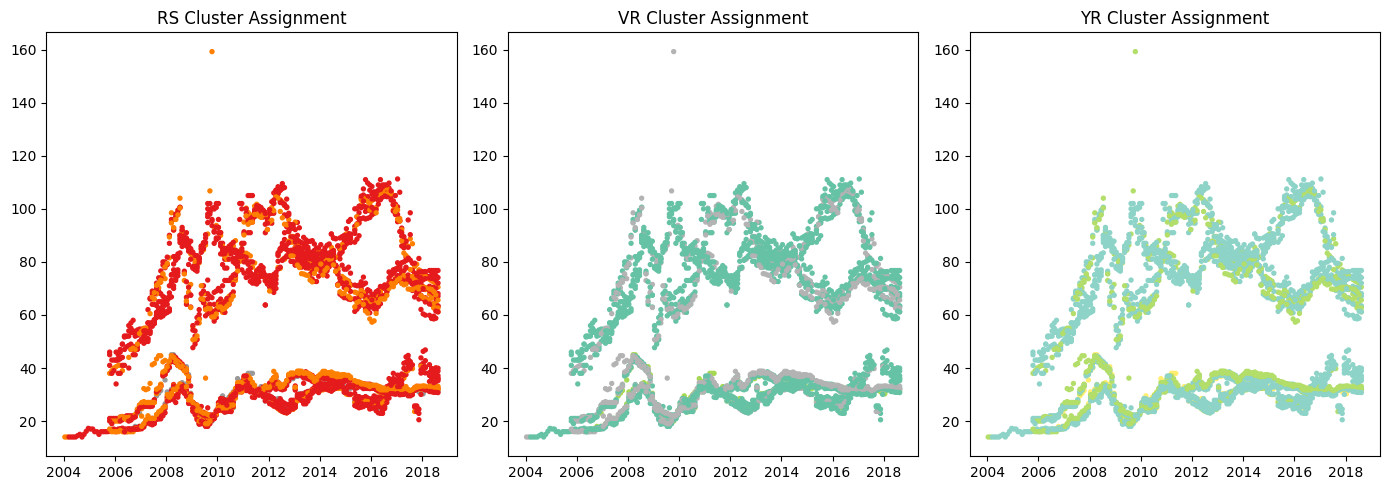

In [19]:
#Cluster Assignment Over Time (RS, VR, YR)
plt.figure(figsize=(14,5))
plt.subplot(1,3,1)
plt.scatter(df['date'], df['price'], c=k_rs, cmap='Set1', s=8)
plt.title('RS Cluster Assignment')
plt.subplot(1,3,2)
plt.scatter(df['date'], df['price'], c=k_vr, cmap='Set2', s=8)
plt.title('VR Cluster Assignment')
plt.subplot(1,3,3)
plt.scatter(df['date'], df['price'], c=k_yr, cmap='Set3', s=8)
plt.title('YR Cluster Assignment')
plt.tight_layout()
plt.show()

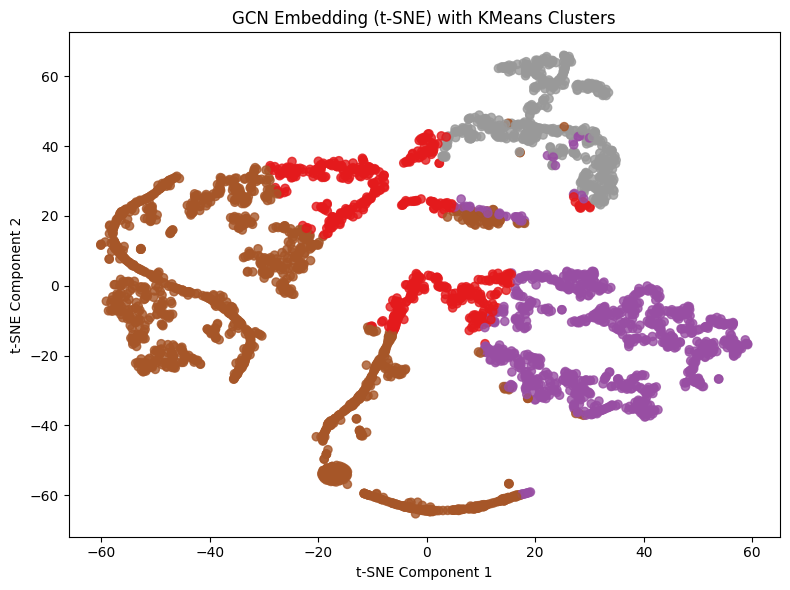

In [20]:
# t-SNE 2D Plot Colored by KMeans Clusters
plt.figure(figsize=(8,6))
plt.scatter(emb_2d[:,0], emb_2d[:,1], c=clusters_km, cmap='Set1', s=35, alpha=0.8)
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.title('GCN Embedding (t-SNE) with KMeans Clusters')
plt.tight_layout()
plt.show()


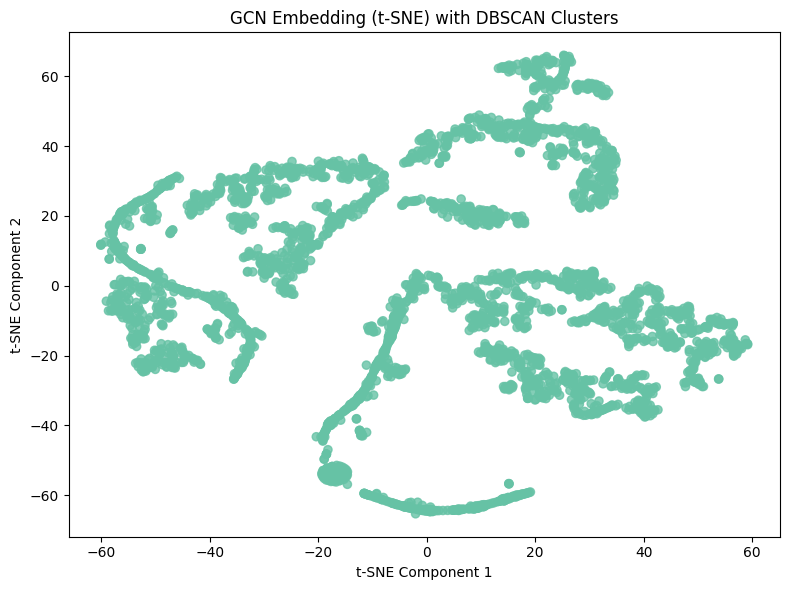

In [21]:
#t-SNE 2D Plot Colored by DBSCAN Clusters
plt.figure(figsize=(8,6))
plt.scatter(emb_2d[:,0], emb_2d[:,1], c=clusters_db, cmap='Set2', s=35, alpha=0.8)
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.title('GCN Embedding (t-SNE) with DBSCAN Clusters')
plt.tight_layout()
plt.show()

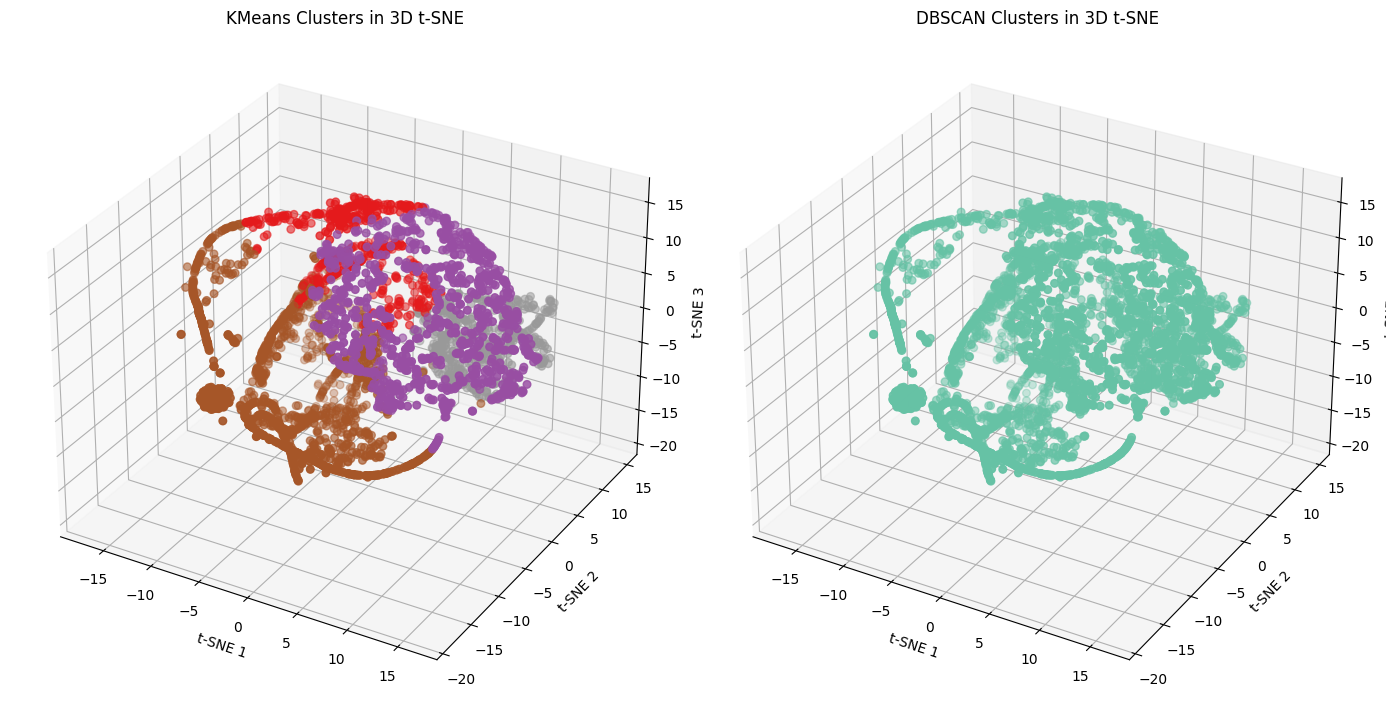

In [22]:
#t-SNE 3D Plot (KMeans and DBSCAN)
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(14,7))
ax1 = fig.add_subplot(1,2,1, projection='3d')
ax1.scatter(emb_3d[:,0], emb_3d[:,1], emb_3d[:,2], c=clusters_km, cmap='Set1', s=30)
ax1.set_title('KMeans Clusters in 3D t-SNE')
ax1.set_xlabel('t-SNE 1')
ax1.set_ylabel('t-SNE 2')
ax1.set_zlabel('t-SNE 3')

ax2 = fig.add_subplot(1,2,2, projection='3d')
ax2.scatter(emb_3d[:,0], emb_3d[:,1], emb_3d[:,2], c=clusters_db, cmap='Set2', s=30)
ax2.set_title('DBSCAN Clusters in 3D t-SNE')
ax2.set_xlabel('t-SNE 1')
ax2.set_ylabel('t-SNE 2')
ax2.set_zlabel('t-SNE 3')

plt.tight_layout()
plt.show()

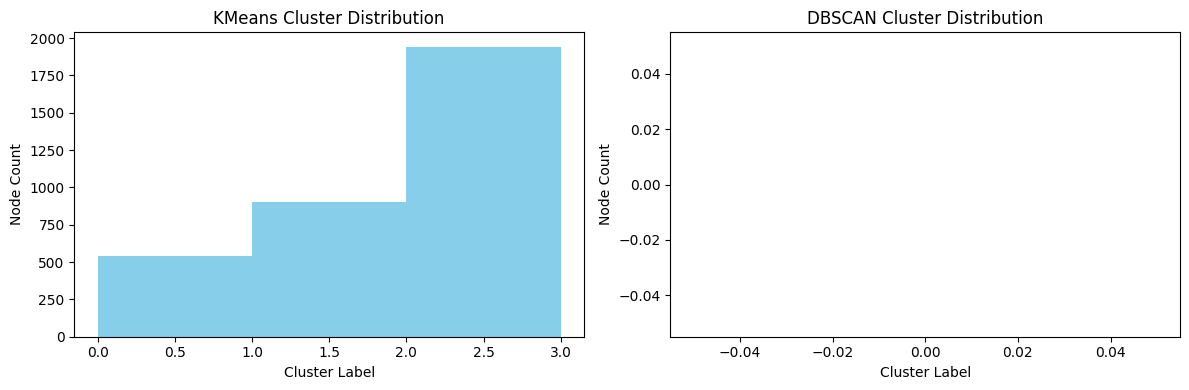

In [23]:
#Cluster Distribution Bar Plots
fig, axes = plt.subplots(1,2, figsize=(12,4))
axes[0].hist(clusters_km, bins=np.unique(clusters_km), color='skyblue')
axes[0].set_title('KMeans Cluster Distribution')
axes[0].set_xlabel('Cluster Label')
axes[0].set_ylabel('Node Count')

axes[1].hist(clusters_db, bins=np.unique(clusters_db), color='salmon')
axes[1].set_title('DBSCAN Cluster Distribution')
axes[1].set_xlabel('Cluster Label')
axes[1].set_ylabel('Node Count')
plt.tight_layout()
plt.show()


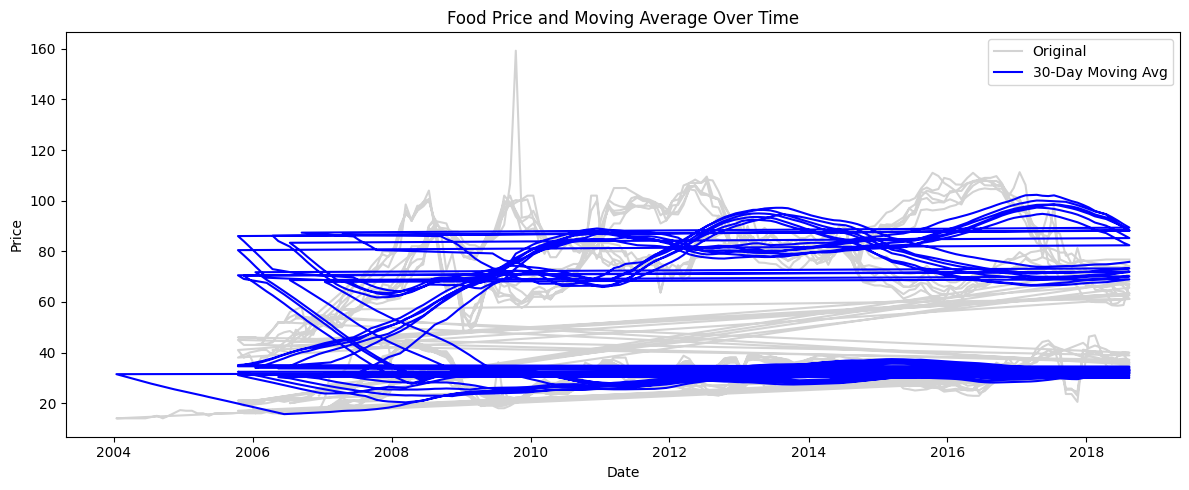

In [24]:
#Moving Average Plot (Price Trends)
plt.figure(figsize=(12,5))
ma_win = 30
plt.plot(df['date'], df['price'], color='lightgray', label='Original')
plt.plot(df['date'], df['price'].rolling(window=ma_win).mean(), color='blue', label=f'{ma_win}-Day Moving Avg')
plt.xlabel('Date')
plt.ylabel('Price')
plt.title('Food Price and Moving Average Over Time')
plt.legend()
plt.tight_layout()
plt.show()